# DL project - classifying emotions from facial images
*Group 17 - Dorothy Modrall Sperling, Manuel Schönberger, Lea Roncero*

## 0. Dataset description

For our deep learning project, we use the FER+ dataset that contains ~28.700 pictures of facial expressions and was proposed in the assignment specification.

###  Features of the Dataset

**Emotion**
- Represents the class label for the facial expression depicted in the image.
- It is an integer value ranging from `0` to `6`, corresponding to seven different emotions:
  - `0`: Angry  
  - `1`: Disgust  
  - `2`: Fear  
  - `3`: Happy  
  - `4`: Sad  
  - `5`: Surprise  
  - `6`: Neutral  

**Pixels**
- A string of pixel values representing a `48x48` grayscale image.
- Contains `2304` comma-separated values (`48 x 48 = 2304`), where each value is an intensity level in the range `0-255`.

## 1. Importing libraries and loading the data

In [5]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from utils.preprocessing import load_data, split_data, oversample_data

First, we load the data into a pandas dataframe.

In [6]:
data_unprocessed = load_data("data/train.csv")
print(data_unprocessed.head(10))

   emotion                                             pixels
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        0  151 150 147 155 148 133 111 140 170 174 182 15...
2        2  231 212 156 164 174 138 161 173 182 200 106 38...
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...
6        4  20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...
7        3  77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...
8        3  85 84 90 121 101 102 133 153 153 169 177 189 1...
9        2  255 254 255 254 254 179 122 107 95 124 149 150...


In [7]:
# Checking Shape of data
data_unprocessed.shape

(28709, 2)

## 2. Data Visualization

We visualize a few sample images to get a feel for what our dataset looks like.

In [8]:
emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_labels

{0: 'Angry',
 1: 'Disgust',
 2: 'Fear',
 3: 'Happy',
 4: 'Sad',
 5: 'Surprise',
 6: 'Neutral'}

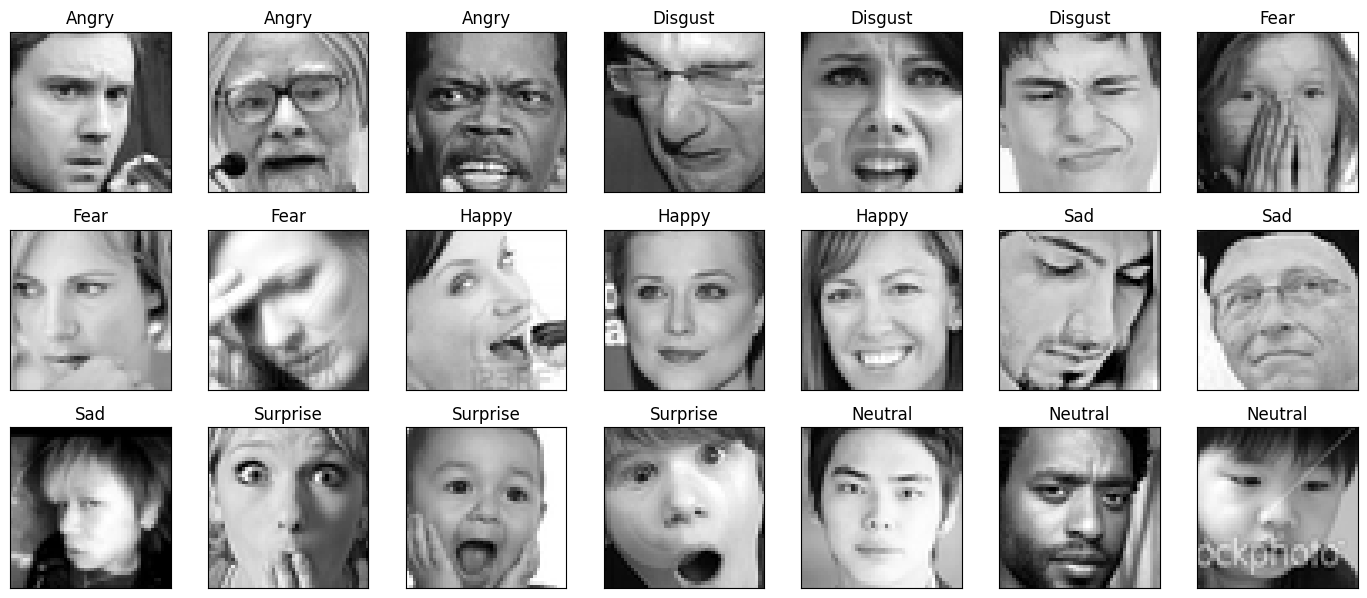

In [9]:
fig = plt.figure(1, (14, 14))
k = 0
for label in sorted(data_unprocessed.emotion.unique()):
    for j in range(3):
        px = data_unprocessed[data_unprocessed.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_labels[label])
        plt.tight_layout()

Next, we check the emotion class distribution

emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64


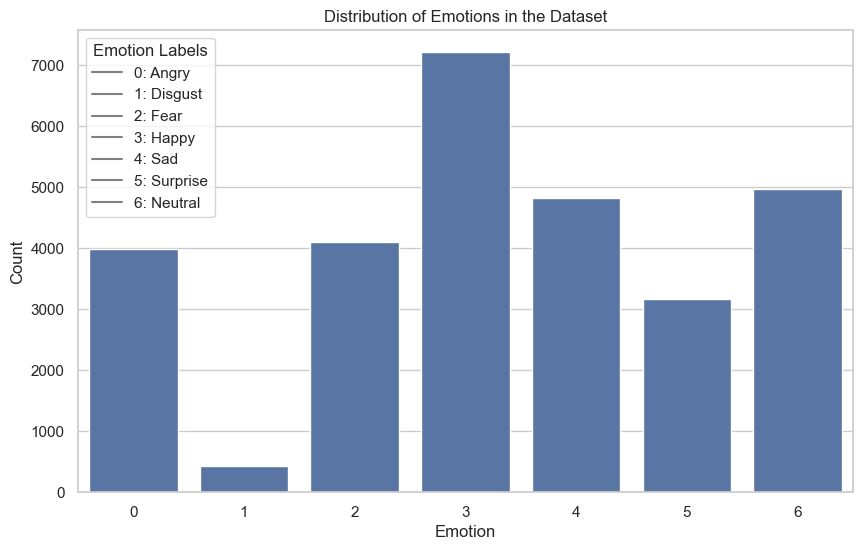

In [10]:
# Checking value counts
print(data_unprocessed['emotion'].value_counts())

# Plotting the above distribution
plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
ax = sns.countplot(x="emotion", data=data_unprocessed)

legend_handles = [plt.Line2D([0], [0], color='gray', label=f"{k}: {v}") for k, v in emotion_labels.items()]
plt.legend(handles=legend_handles, title="Emotion Labels", loc="upper left")

# Adding plot title and labels
plt.title("Distribution of Emotions in the Dataset")
plt.xlabel("Emotion")
plt.ylabel("Count")

plt.show()

From the above chart, we can observe that the data is highly imbalanced and that for some emotions (e.g. `Disgust`) we have a very small number of images.

## 2. Preprocessing data

In [11]:
data_unprocessed.isnull().values.any()

False

### Split the dataset into train and validation data

We use our full dataset object and split it into training and validation sets (80% and 20%). We also visualize the training and validation sets to see the class distribution.


In [12]:
# function to visualize the label distribution
def visualize_label_distribution(df, emotion_labels, title, verbose=True, colors=None):
    """
    Visualizes the label distribution in a pandas DataFrame dataset.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset to analyze, should contain an 'emotion' column.
    emotion_labels : dict
        A dictionary mapping label indices to emotion names.
    title : str
        The title for the visualization.
    verbose : bool, optional
        Whether to print dataset size and class distribution. Default is True.
    colors : list, optional
        List of colors for the bar chart. Default is None.

    Returns
    -------
    None
    """

    # Extract all labels from the 'emotion' column of the DataFrame
    all_labels = df['emotion'].values

    # Count occurrences of each label
    class_counts = Counter(all_labels)

    # Sort labels by class index
    sorted_keys = sorted(class_counts.keys())
    sorted_counts = [class_counts[key] for key in sorted_keys]
    sorted_labels = [emotion_labels.get(key, f"Class {key}") for key in sorted_keys]

    # Verbose Output
    if verbose:
        print(f"{title} Dataset Size: {len(df)}")
        print(f"{title} Class Distribution: {class_counts}")

    # Visualization
    plt.bar(sorted_keys, sorted_counts, tick_label=sorted_labels, color=colors)
    plt.xlabel("Emotion Classes")
    plt.ylabel("Frequency")
    plt.title(f"{title} Label Distribution (Total: {len(df)})")
    plt.show()


Training Dataset Size: 22967
Training Class Distribution: Counter({3: 5772, 6: 3972, 4: 3864, 2: 3277, 0: 3196, 5: 2537, 1: 349})


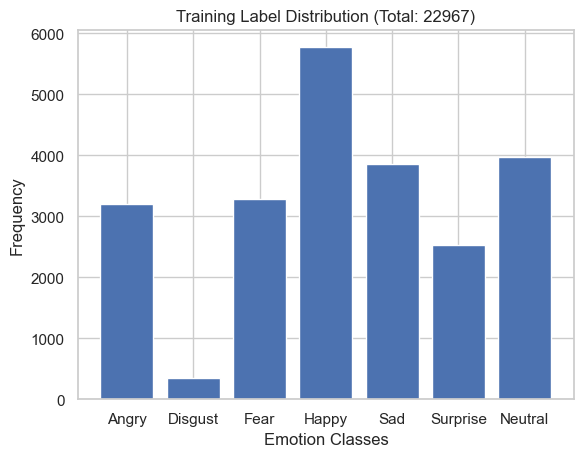

Validation Dataset Size: 5742
Validation Class Distribution: Counter({3: 1443, 6: 993, 4: 966, 2: 820, 0: 799, 5: 634, 1: 87})


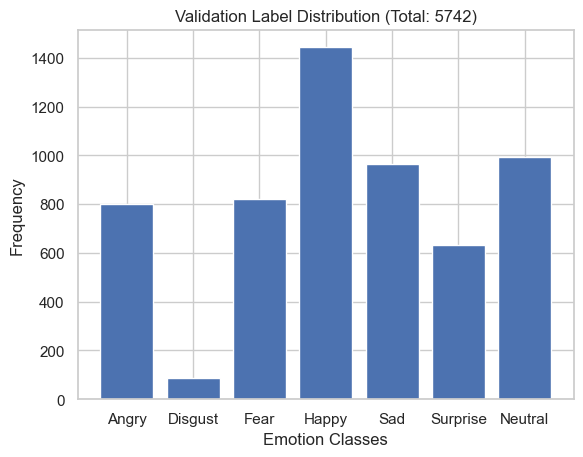

In [13]:
train_df, val_df = split_data(data_unprocessed, train_split=0.8)

emotion_labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

visualize_label_distribution(train_df, emotion_labels, "Training")
visualize_label_distribution(val_df, emotion_labels, "Validation")

### Oversampling

As we have seen in the plots, the data is highly inbalanced. Therefore, we first over-sample the minority classes in the training set using RandomOverSampler so that the emotion classes are evenly distributed

In [14]:
oversampled_train_data = oversample_data(train_df['pixels'], train_df['emotion'])
oversampled_train_data = oversampled_train_data.reset_index(drop=True)

# Print the new shape and label distribution
print(oversampled_train_data.shape)
print(oversampled_train_data['emotion'].value_counts())


(40404, 2)
emotion
0    5772
3    5772
6    5772
1    5772
4    5772
2    5772
5    5772
Name: count, dtype: int64


## 3. Save data

In [15]:
# save the oversampled training data
oversampled_train_data.to_csv("data/oversampled_train.csv", index=False)

# save the validation data
val_df.to_csv("data/validation.csv", index=False)